In [2]:
### Please run this cell before continuing.

library(tidyverse)
library(repr)
library(tidymodels)
library(GGally)
options(repr.matrix.max.rows = 6)
set.seed(2022) 

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ rsample      1.0.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.2     ✔ workflows    1.0.0
✔ modeldata    1.0.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.0     ✔ yardstick    1.0.0
✔ recipes      1.0.1     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks r

In [3]:
# reading and cleaning dataset

heart_disease_data <- read_csv("https://raw.githubusercontent.com/labellali/dsci-100-2022w1-group-169/main/data/heart_disease_dataset.csv")
heart_disease_data <- heart_disease_data |>
    rename(age = Column1,
            sex = Column2,
                            chest_pain = Column3,
                            resting_blood_pressure = Column4,
                            cholesterol = Column5,
                            fasting_blood_sugar = Column6,
                            rest_ecg = Column7,
                            max_heart_rate = Column8,
                            exercised_ind_angina = Column9,
                            oldpeak = Column10,
                            slope = Column11,
                            ca = Column12,
                            thal = Column13,
                            num = Column14) |>
    mutate(sex = as.factor(sex),
          chest_pain = as.factor(chest_pain),
          fasting_blood_sugar = as.factor(fasting_blood_sugar),
          rest_ecg = as.factor(rest_ecg),
          exercised_ind_angina = as.factor(exercised_ind_angina),
          num = as.factor(num),
          thal = na_if(thal, '?'),
          thal = as.factor(thal),
          ca = na_if(ca, '?'), 
          ca = as.numeric(ca),
          num = replace(num, num == 2, 1),
          num = replace(num, num == 3, 1),
          num = replace(num, num == 4, 1)) |> 
    select(resting_blood_pressure,
           cholesterol,
           max_heart_rate,
           num) |>
    filter(resting_blood_pressure != is.na(resting_blood_pressure),
           cholesterol != is.na(cholesterol),
           max_heart_rate != is.na(max_heart_rate),
           num != is.na(num))
heart_disease_data

count_tmp <- heart_disease_data |>
    group_by(num) |>
    summarize(n = n())
count_tmp

Rows: 303 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (2): Column12, Column13
dbl (12): Column1, Column2, Column3, Column4, Column5, Column6, Column7, Col...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


resting_blood_pressure,cholesterol,max_heart_rate,num
<dbl>,<dbl>,<dbl>,<fct>
145,233,150,0
160,286,108,1
120,229,129,1
⋮,⋮,⋮,⋮
130,131,115,1
130,236,174,1
138,175,173,0


num,n
<fct>,<int>
0,164
1,139


Here we have read in our data with readable column names and categorized our classification variables into numbers to help us with our predictive model. We have chosen to only include resting_blood_pressure, cholesterol, max_heart_rate and num. Furthermore 

In [4]:
# splitting data into initial and training datasets

heart_disease_split <- initial_split(heart_disease_data, prop = 0.75, strata = num)
training_data <- training(heart_disease_split)
testing_data <- testing(heart_disease_split)

In [5]:
# looking at the number of observations in each class to predict

training_data_count <- training_data |>
    group_by(num) |>
    summarize(n = n())

training_data_count

num,n
<fct>,<int>
0,123
1,104


In [6]:
# finding range of each numeric variable

training_data_max <- training_data |>
    select(-num) |>
    map_df(max, na.rm = TRUE)

training_data_min <- training_data |>
    select(-num) |>
    map_df(min, na.rm = TRUE)

training_data_ranges <- tibble(training_data_max - training_data_min)

training_data_ranges

resting_blood_pressure,cholesterol,max_heart_rate
<dbl>,<dbl>,<dbl>
98,291,131


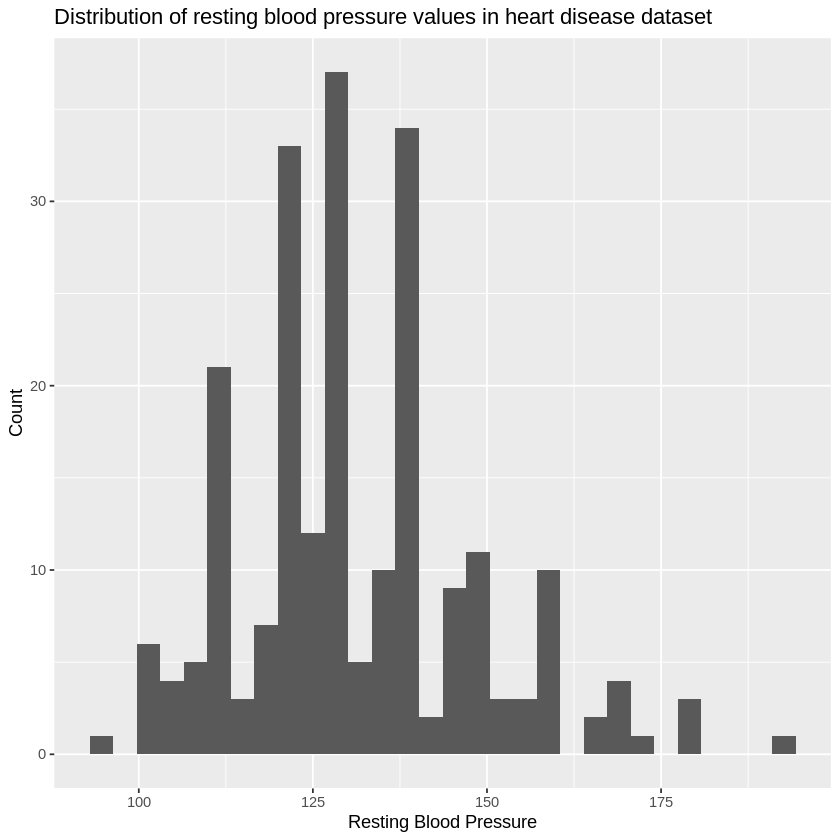

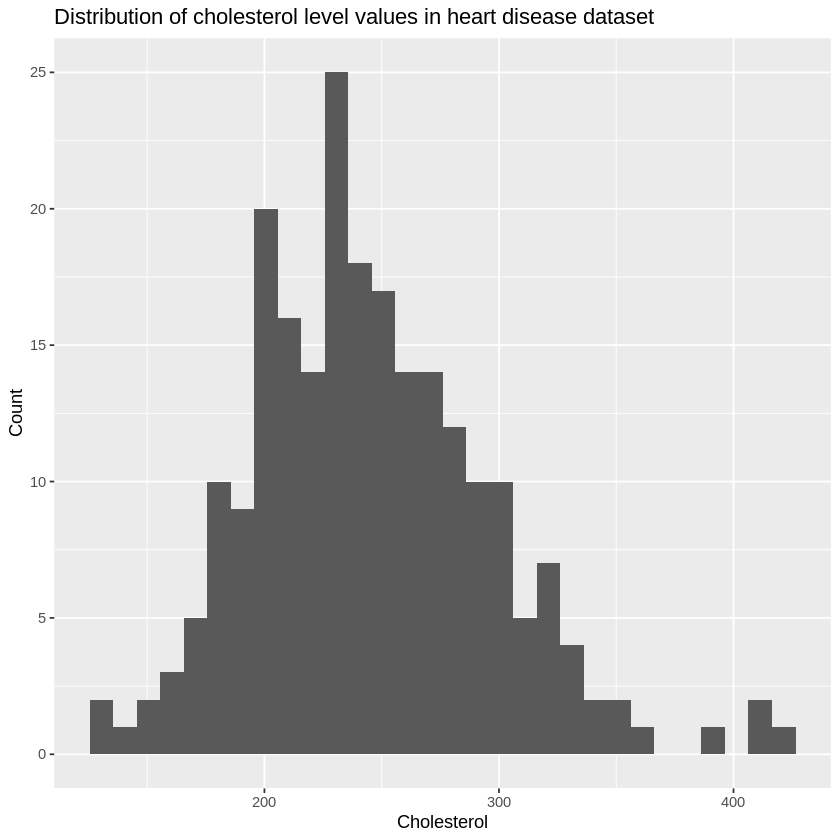

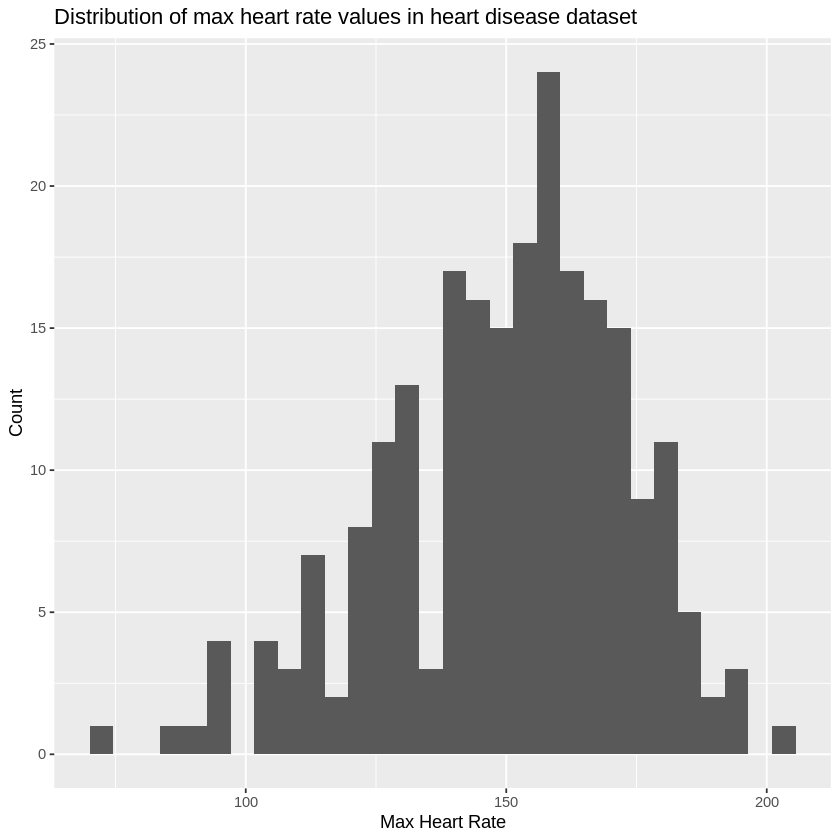

In [7]:
# histograms of every numeric variable

heart_training_hist_resting_blood_pressure<- training_data %>%
    ggplot(aes(x=resting_blood_pressure))+
    geom_histogram(bins = 30)+
    labs(x = "Resting Blood Pressure", y = "Count") +
    ggtitle("Distribution of resting blood pressure values in heart disease dataset")
heart_training_hist_resting_blood_pressure

heart_training_hist_cholesterol<- training_data %>%
    ggplot(aes(x=cholesterol))+
    geom_histogram(bins = 30)+
    labs(x = "Cholesterol", y = "Count") +
    ggtitle("Distribution of cholesterol level values in heart disease dataset")
heart_training_hist_cholesterol

heart_training_max_heart_rate<- training_data %>%
    ggplot(aes(x=max_heart_rate))+
    geom_histogram(bins = 30)+
    labs(x = "Max Heart Rate", y = "Count") +
    ggtitle("Distribution of max heart rate values in heart disease dataset")
heart_training_max_heart_rate

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



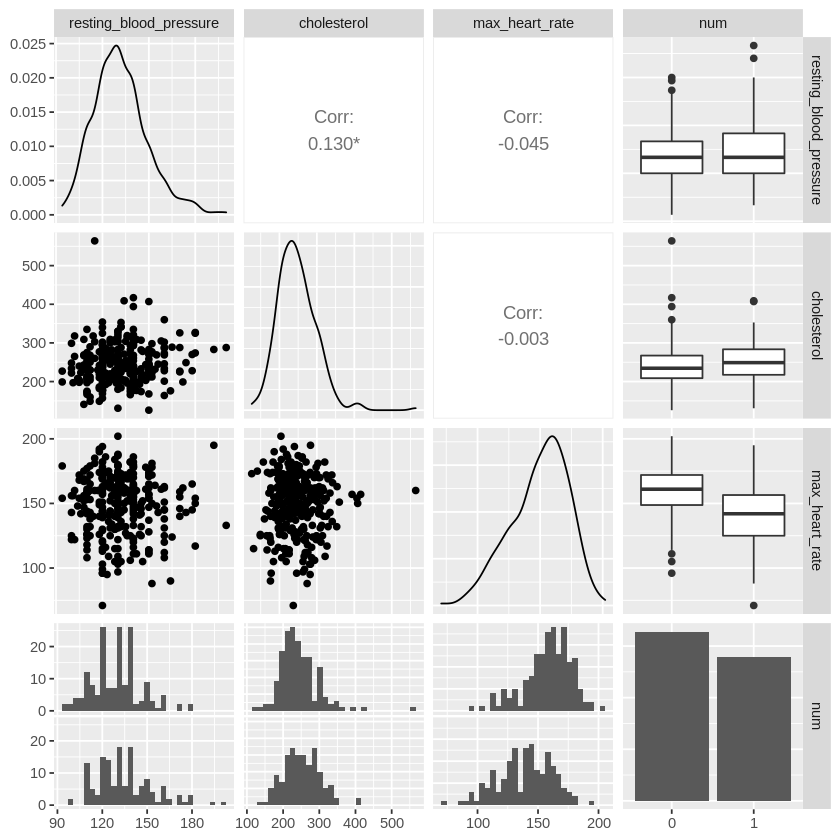

In [8]:
# comparing variable correlations

correlations <- ggpairs(heart_disease_data)
correlations

In [9]:
# balancing and scaling the data in the classification recipe

heart_disease_recipe <- recipe(num ~ ., data = training_data) |>
    step_center(all_predictors()) |>
    step_scale(all_predictors())

In [10]:
# creating the tuning classification model 

knn_tune <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
    set_engine("kknn") |>
    set_mode("classification")

In [11]:
# cross-validation on training data to determine best k-value

k_values <- tibble(neighbors = c(1:50))

heart_disease_vfold <- vfold_cv(training_data, v = 5, strata = num)

knn_tune_fit <- workflow() |>
    add_recipe(heart_disease_recipe) |>
    add_model(knn_tune) |>
    tune_grid(resamples = heart_disease_vfold, grid = k_values) |>
    collect_metrics()

knn_tune_fit

! Fold1: internal:
  No observations were detected in `truth` for level(s): '2', '3', '4'
  Computation will proceed by ignoring those levels.

! Fold2: internal:
  No observations were detected in `truth` for level(s): '2', '3', '4'
  Computation will proceed by ignoring those levels.

! Fold3: internal:
  No observations were detected in `truth` for level(s): '2', '3', '4'
  Computation will proceed by ignoring those levels.

! Fold4: internal:
  No observations were detected in `truth` for level(s): '2', '3', '4'
  Computation will proceed by ignoring those levels.

! Fold5: internal:
  No observations were detected in `truth` for level(s): '2', '3', '4'
  Computation will proceed by ignoring those levels.



neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,multiclass,0.5626921,5,0.04002156,Preprocessor1_Model01
1,roc_auc,hand_till,0.5605714,5,0.04098848,Preprocessor1_Model01
2,accuracy,multiclass,0.5626921,5,0.04002156,Preprocessor1_Model02
⋮,⋮,⋮,⋮,⋮,⋮,⋮
49,roc_auc,hand_till,0.7442480,5,0.02918142,Preprocessor1_Model49
50,accuracy,multiclass,0.6735529,5,0.02270653,Preprocessor1_Model50
50,roc_auc,hand_till,0.7422579,5,0.02450199,Preprocessor1_Model50


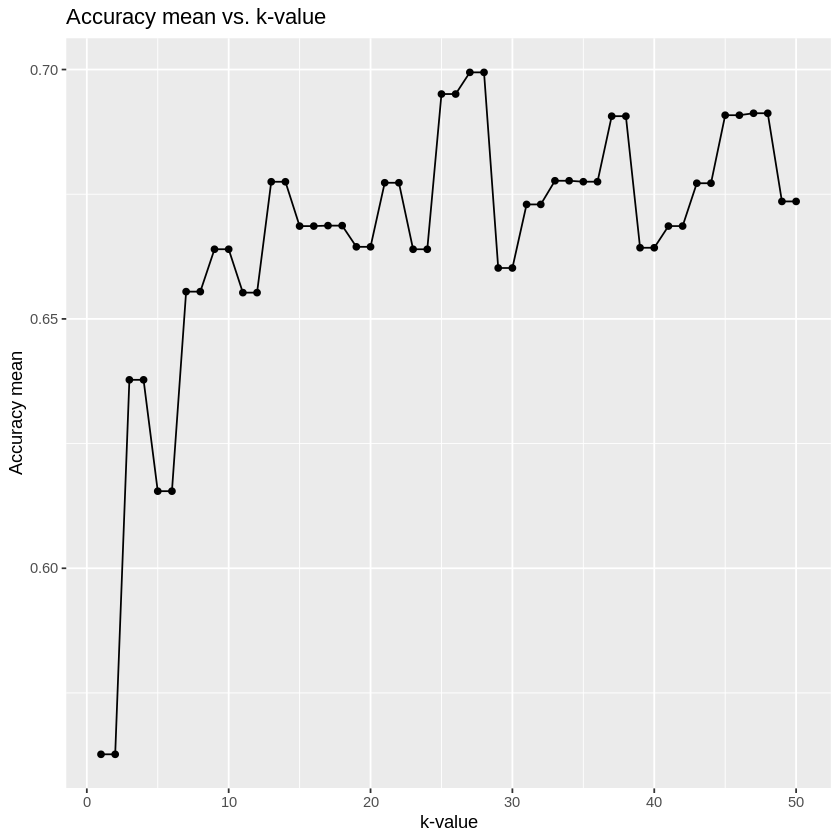

In [12]:
# plotting accuracy values to determine the best k-value

knn_tune_accuracies <- knn_tune_fit |>
    filter(.metric == "accuracy") |>
    select(neighbors, mean)

accuracies <- ggplot(knn_tune_accuracies, aes(x = neighbors, y = mean)) +
    geom_point() +
    geom_line() +
    labs(x = "k-value", y = "Accuracy mean") +
    ggtitle("Accuracy mean vs. k-value")

accuracies

In [13]:
# choosing the best k-value

knn_tune_preview <- knn_tune_accuracies |>
    filter(neighbors %in% c(25:30))
knn_tune_preview

chosen_k <- 24

neighbors,mean
<int>,<dbl>
25,0.6950856
26,0.6950856
27,0.6994335
28,0.6994335
29,0.6602064
30,0.6602064


In [16]:
# creating model with chosen k

knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = chosen_k) |>
    set_engine("kknn") |>
    set_mode("classification")

knn_fit <- workflow() |>
    add_recipe(heart_disease_recipe) |>
    add_model(knn_spec) |>
    fit(data = training_data)

#### Methods:
* Explain how you will conduct either your data analysis and which variables/columns you will use. (Note - you do not need to use all variables/columns that exist in the raw data set. In fact, that's often not a good idea. For each variable think: is this a useful variable for prediction?)
* Describe at least one way that you will visualize the results

In our data set, there are 14 columns:

* age (years)
* sex (1 = male, 0 = female)
* chest_pain (type) Value 1: typical angina Value 2: atypical angina Value 3: non-anginal pain Value 4: asymptomatic
* resting_blood_pressure (in mm Hg on admission to the hospital)
* cholesterol (serum cholestoral in mg/dl)
* fasting_blood_sugar (> 120 mg/dl, 1 = true; 0 = false)
* rest_ecg (resting electrocardiographic results)
* max_heart_rate (maximum heart rate achieved)
* exercised_ind_angina (exercise induced angina, 1 = yes; 0 = no)
* oldpeak (ST depression induced by exercise relative to rest)
* slope (the slope of the peak exercise ST segment) Value 1: upsloping Value 2: flat Value 3: downsloping
* ca (number of major vessels (0-3) colored by flourosopy)
* thal (3 = normal; 6 = fixed defect; 7 = reversable defect)
* num (diagnosis of heart disease (angiographic disease status)) Value 0: < 50% diameter narrowing Value 1: > 50% diameter narrowing

We will select the columns resting_blood_pressure, cholesterol, max_heart_rate, and num, this is a change from our proposal; because the correlation was better when did not include age, sex, chest_pain and fasting_blood_pressure.

Our assumption was that a high resting blood pressure would lead to an increased probability of heart disease because a high blood pressure leads to various different health complications including heart disease (source). We selected cholestrol because high colestrol is directly related to issues in blood flow that could lead to a heart attack (source), which told us that this may also be linked to heart disease. As stated we previously found that including other variables messed with the accuracy of our model so we chose to only include these as those variables would not be helpful in prediction. 

To increase the accuracy of the data prediction, we optimize the data itself. In the previous version, the "num" column represented four different kinds of heart disease with values 1,2,3, and 4. It also had a value "0" for patients who don't have heart diease. We simplified this to make it so that we only have two values in this column, "0" and "1", to represent whether or not a patient has heart disease. This is more aligned with the question that we are asking to see if we can predict heart disease given the variables of their health characteristics we  are using. 

In the next step, we do the data classification. After using cross-validation to calculate accuracy for each value of 𝐾 in a reasonable range, we create a plot to choose the best k for our model with the most fantastic accuracy.

Finally, we choose the best k, 24, and create the model for the selected k.


#### Discussion:
##### Summarize what you found

##### Discuss whether this is what you expected to find?

There are three expectations we mentioned in our proposal.
  * A link between particular variables and heart disease
  
People who have heart disease are likely to have a little bit higher resting_blood_pressure, slightly higher cholesterol, and lower cholesterol
  * A list of variables that are linked to heart disease and the variable that has the most significant effect on the likelihood of heart disease
  
We found that resting_blood_pressure, cholesterol, and max_heart_rate is related to heart disease.
Amount all the variables, max_heart_rate has the most significant effect on the likelihood of heart disease.
  * An accurate predictive model that can help detect the possibility of heart disease
  
We already have the predictive classification model, which has a k value of 24.


##### Discuss what impact could such findings have?

##### Discuss what future questions could this lead to?




#### References:

Here is an annotated list of five references that relate to heart disease. To find them, we searched google scholar for scholarly articles from the past five years the included the terms "heart", "disease", "predict", and "data"

##### Zriqat, I. A., Altamimi, A. M., & Azzeh, M. (2017). A comparative study for predicting heart diseases using data mining classification methods. arXiv preprint arXiv:1704.02799.

    Incorrect diagnosis of heart disease has led many researchers to investigate better predictive methods. This paper uses "five data mining classifying algorithms, with large datasets" (abstract para 1) to propose a more effective decision making model. Five classifiers were used: Naïve Bayes, Decision Tree, Discriminant, Random Forest, and Support Vector Machine. Decision tree was the most accurate with a 99.0% rate.


##### Latha, C. B., & Jeeva, S. C. (2019). Improving the accuracy of prediction of heart disease risk based on ensemble classification techniques. Informatics in Medicine Unlocked, 16, 100203. https://doi.org/10.1016/j.imu.2019.100203


    Machine learning can predict using known data via classification methods that recognize patterns. This paper proposes the use of ensemble classification, that is using multiple classifiers. Ensemble classification was applied to predicting heart disease, and this paper also shows in purpose in "predict[ing] disease at an early stage" (abstract para 1). Ensemble classification such as bagging and boosting improved the accuracy of poor classifiers, and it increased week prediction models by 7%.


##### Mohan, S., Thirumalai, C., & Srivastava, G. (2019). Effective heart disease prediction using hybrid machine learning techniques. IEEE Access, 7, 81542–81554. https://doi.org/10.1109/access.2019.2923707


    Machine Learning is effective at predicting heart disease, one of the leading causes of death in humans. ML has been used in the Internet of Things. The model proposed in this paper uses various classification methods to predict heart disease, with an accuracy of 88.7%.


##### Rao, J. N., & Prasad, R. S. (2021). An enhanced novel Dynamic Data Processing (ENDDP) algorithm for predicting heart disease in machine learning. International Journal of Scientific Research in Computer Science, Engineering and Information Technology, 94–104. https://doi.org/10.32628/cseit206429


    Machine Learning is increasing in development and can solve complex problems, such as the most difficult one in the medical world, the prediction of heart disease. Improving the algorithms that use complex data sets can improve diagnoses in the medical world. "In this article, An Enhanced New Dynamic Data Processing (ENDDP) Algorithm is developed to predict the early stages of heart disease" (abstract para 1).


##### Reddy, G. T., Reddy, M. P., Lakshmanna, K., Rajput, D. S., Kaluri, R., & Srivastava, G. (2019). Hybrid genetic algorithm and a fuzzy logic classifier for heart disease diagnosis. Evolutionary Intelligence, 13(2), 185–196. https://doi.org/10.1007/s12065-019-00327-1 


    "For the past two decades, most of the people from developing countries [have been] suffering from heart disease" (abstract para 1). Early diagnosis can mitigate risk and cost. The adaptive genetic algorithm with fuzzy logic (AGAFL) is a prediction model for heart disease. Experiments have proved this model has outperformed prior models.

